# Tensor factorization

With help from:

https://medium.com/yadb/tensor-factorization-for-graph-analysis-in-python-590df44c9f6c

In [1]:
import tensorly as tl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
df_April = pd.read_csv('Edinburgh/04.csv')
df_April.started_at = pd.to_datetime(df_April.started_at)
df_April.ended_at = pd.to_datetime(df_April.ended_at)
df_April['trip_duration'] = (df_April.ended_at-df_April.started_at).apply(lambda x : x.seconds/60)

df_trips = df_April[['started_at', 'ended_at', 'trip_duration', 'start_station_id', 'end_station_id']].copy()

station_bridge = {j:i for i,j in enumerate(sorted(df_April.start_station_id.unique()))}

df_trips[['start_station_id', 'end_station_id']] = df_trips[['start_station_id', 'end_station_id']].applymap(lambda x : station_bridge[x])
df_trips['started_floor'] = df_trips.started_at.apply(lambda x:x.floor('15min'))
df_trips['ended_floor'] = df_trips.ended_at.apply(lambda x:x.floor('15min'))

df_trips['weekday'] = df_trips.started_at.apply(lambda x:x.weekday)
df_trips['hour'] = df_trips.started_at.apply(lambda x:x.hour)

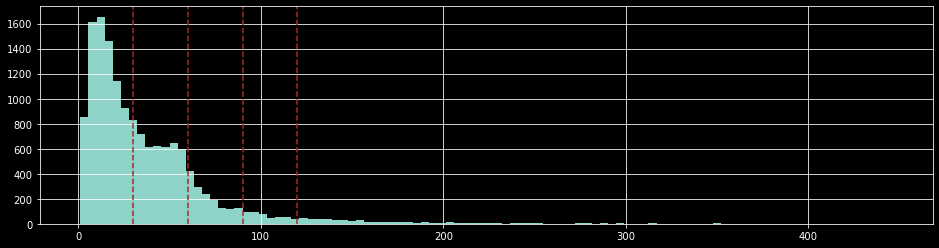

In [3]:
df_trips.trip_duration.hist(bins=100, figsize=(16,4))
plt.axvline(30, color='brown', ls='--')
plt.axvline(60, color='brown', ls='--')
plt.axvline(90, color='brown', ls='--')
plt.axvline(120, color='brown', ls='--')

### Let's try a factorization per hour of the day, to start. 

In [4]:
T = np.zeros((len(df_trips.start_station_id.unique()), len(df_trips.end_station_id.unique()), 24), dtype=float)

for row in df_trips[['hour', 'start_station_id', 'end_station_id']].iterrows():
    T[row[1]['start_station_id'],row[1]['end_station_id'],row[1]['hour']]+=1

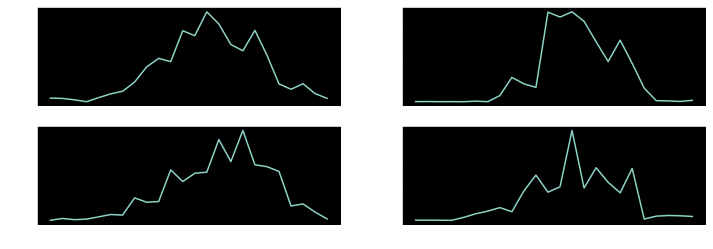

In [5]:
from tensorly.decomposition import non_negative_parafac as NNP

R=4

F=NNP(tensor=T, rank=R, verbose=0)

weights=F[0]
factors=F[1]

Us,Vs,Xs = factors

fig, axes = plt.subplots(2,2, figsize=(12,4))
fig.patch.set_alpha(0)
axes=axes.flatten()

for i in range(R):

    starts = Us[:, i]
    ends = Vs[:, i]
    t_intensity = Xs[:, i]

    axes[i].plot(t_intensity)

plt.show()

### Let's try the core consistency .

C is a negative sum of the reconstruction error. <br>
It is $~ (1 - \frac{\sum \epsilon }{n}$, with $\epsilon$ the reconstruction error (Identity matrix - actual superdiag matrix needed to rebuild T from the factors) : Higher reconstruction error means high |CC| in the negative: we want to maximize both k and CC !

In [6]:
from sktensor import dtensor, cp_als
import imp
import corcondia
imp.reload(corcondia)

In [66]:
mean_CC = lambda x : np.mean([corcondia.corcondia(dtensor(T), components = x) for i in range(5)])

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
x_range = range(1, 10)
plt.plot(x_range, [mean_CC(R) for R in x_range], marker='o')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
x_range = range(1, 150, 8)
plt.plot(x_range, [mean_CC(R) for R in x_range], marker='o')
plt.show()